In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import plot_tree, DecisionTreeRegressor
from sklearn.tree import export_text

# Load data
youth_df = pd.read_csv("youth_data.csv")

# Predictor variables
predictor_vars = [
    'PARCHKHW', 'PARHLPHW', 'PRCHORE2', 'PRLMTTV2', 'PARLMTSN', 'PRGDJOB2',
    'PRPROUD2', 'PRPKCIG2', 'PRMJEVR2', 'PRMJMO', 'PRALDLY2',
    'FRDPCIG2', 'FRDMEVR2', 'FRDMJMON', 'FRDADLY2',
    'SCHFELT', 'TCHGJOB', 'AVGGRADE', 'STNDSCIG', 'STNDSMJ', 'STNDALC', 'STNDDNK'
]

column_rename_map = {
    'PARCHKHW': 'Parents check if homework is done (past year)',
    'PARHLPHW': 'Parents help with homework (past year)',
    'PRCHORE2': 'Parents make youth do chores (past year)',
    'PRLMTTV2': 'Parents limit amount of TV (past year)',
    'PARLMTSN': 'Parents limit time out on school night (past year)',
    'PRGDJOB2': 'Parents say youth did a good job (past year)',
    'PRPROUD2': 'Parents express pride in youth (past year)',
    'PRPKCIG2': 'Parents discourage youth from smoking cigarettes',
    'PRMJEVR2': 'Parents discourage youth from trying marijuana',
    'PRMJMO': 'Parents discourage youth from monthly marijuana use',
    'PRALDLY2': 'Parents discourage youth from daily alcohol use',
    'FRDPCIG2': 'Friends would disapprove if youth smoked cigarettes',
    'FRDMEVR2': 'Friends would disapprove if youth tried marijuana',
    'FRDMJMON': 'Friends would disapprove if youth used marijuana monthly',
    'FRDADLY2': 'Friends would disapprove if youth drank alcohol daily',
    'SCHFELT': 'Youth feels part of school',
    'TCHGJOB': 'Teachers say youth is doing a good job',
    'AVGGRADE': 'Youth’s average school grade',
    'STNDSCIG': 'Perceived student cigarette use (most/all vs few/none)',
    'STNDSMJ': 'Perceived student marijuana use (most/all vs few/none)',
    'STNDALC': 'Perceived student alcohol use (most/all vs few/none)',
    'STNDDNK': 'Perceived student drunkenness frequency (weekly)',
}


# Binary Classification: ALCFLAG

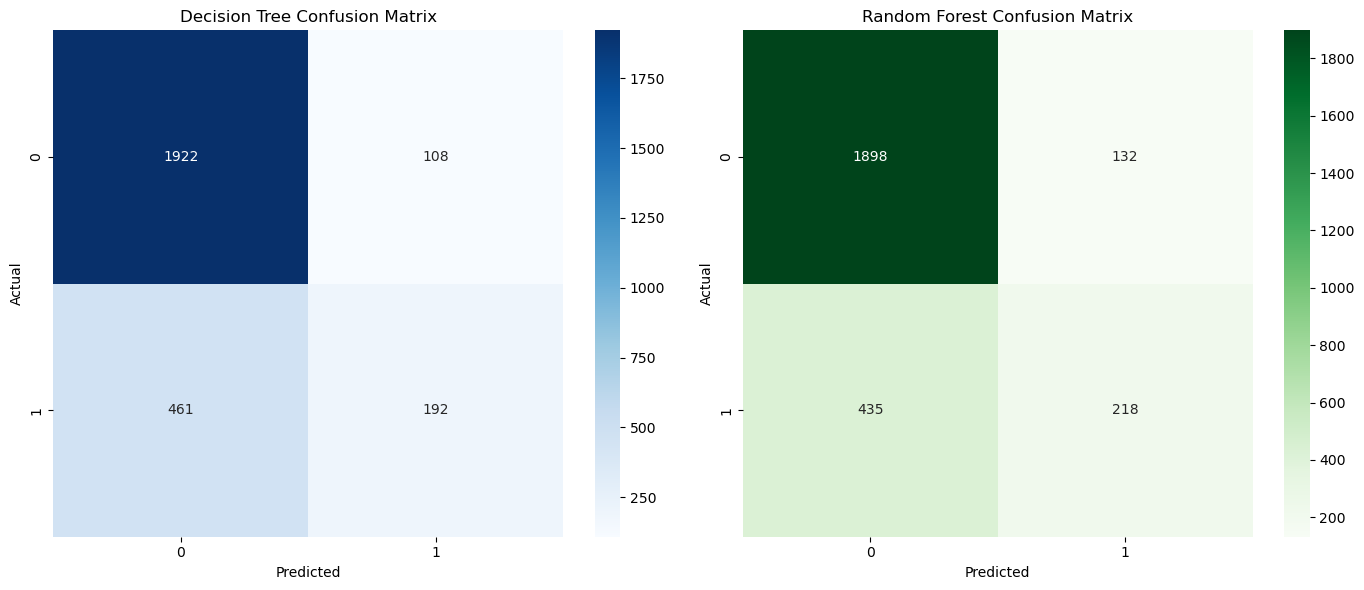

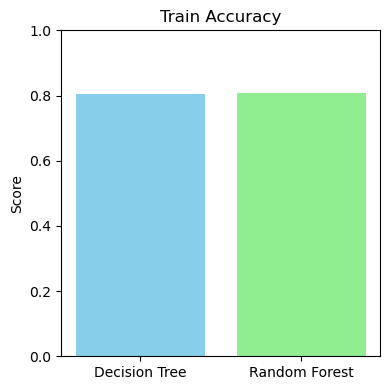

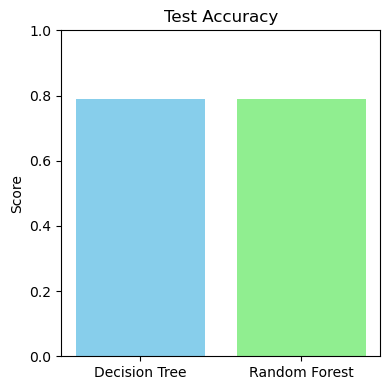

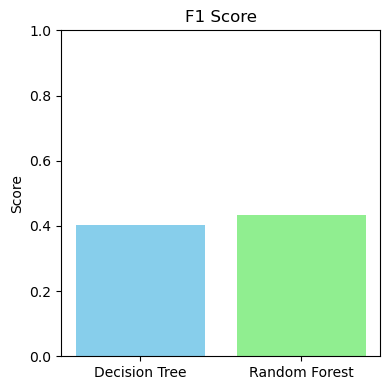

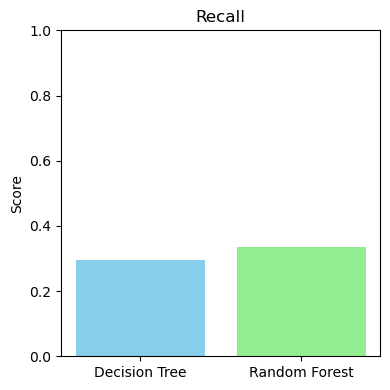

In [43]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

alc_df = youth_df[predictor_vars + ['ALCFLAG']].copy()
alc_df = alc_df.replace([91, 93, 94, 95, 97, 98, 99, 991, 993, 994, 997, 998, 999], np.nan)
alc_df.dropna(inplace=True)

X = alc_df[predictor_vars]
y = alc_df['ALCFLAG']
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

temp_tree = DecisionTreeClassifier(max_depth=5, random_state=42)
temp_tree.fit(X_train_full, y_train)
feature_importances = pd.Series(temp_tree.feature_importances_, index=X.columns)
top_10_features = feature_importances.sort_values(ascending=False).head(10).index.tolist()
if 'STNDALC' in top_10_features:
    top_10_features.remove('STNDALC')

X_train = X_train_full[top_10_features]
X_test = X_test_full[top_10_features]

scores = []
depths = list(range(1, 21))
for depth in depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    scores.append(accuracy_score(y_test, preds))

best_depth = depths[scores.index(max(scores))]
best_model = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
best_model.fit(X_train, y_train)

y_pred_dt = best_model.predict(X_test)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_search_rf.fit(X_train, y_train)
y_pred_rf = grid_search_rf.best_estimator_.predict(X_test)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Decision Tree Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Random Forest Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()
from sklearn.metrics import accuracy_score, f1_score, recall_score

# Decision Tree metrics
train_acc_dt = accuracy_score(y_train, best_model.predict(X_train))
test_acc_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)

# Random Forest metrics
train_acc_rf = accuracy_score(y_train, grid_search_rf.best_estimator_.predict(X_train))
test_acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)

# Display metrics
# print("Decision Tree Metrics:")
# print(f"Train Accuracy: {train_acc_dt:.4f}")
# print(f"Test Accuracy: {test_acc_dt:.4f}")
# print(f"F1 Score: {f1_dt:.4f}")
# print(f"Recall: {recall_dt:.4f}")
# print("\nRandom Forest Metrics:")
# print(f"Train Accuracy: {train_acc_rf:.4f}")
# print(f"Test Accuracy: {test_acc_rf:.4f}")
# print(f"F1 Score: {f1_rf:.4f}")
# print(f"Recall: {recall_rf:.4f}")

import matplotlib.pyplot as plt

# Metrics for plotting
metrics = ['Train Accuracy', 'Test Accuracy', 'F1 Score', 'Recall']
dt_scores = [train_acc_dt, test_acc_dt, f1_dt, recall_dt]
rf_scores = [train_acc_rf, test_acc_rf, f1_rf, recall_rf]

# Create a small bar chart for each metric
for i, metric in enumerate(metrics):
    plt.figure(figsize=(4, 4))
    plt.bar(['Decision Tree', 'Random Forest'], [dt_scores[i], rf_scores[i]], color=['skyblue', 'lightgreen'])
    plt.ylim(0, 1)
    plt.title(metric)
    plt.ylabel('Score')
    plt.tight_layout()
    plt.show()


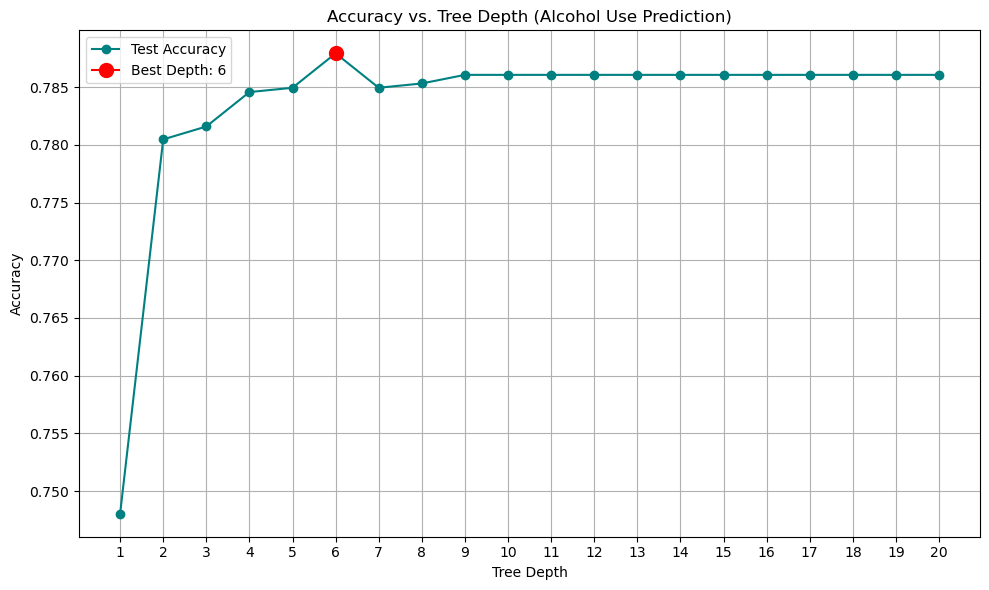

In [46]:
import matplotlib.pyplot as plt

best_score = max(scores)
best_depth_index = scores.index(best_score)
best_depth_value = depths[best_depth_index]

plt.figure(figsize=(10, 6))
plt.plot(depths, scores, marker='o', linestyle='-', color='teal', label='Test Accuracy')

plt.plot(best_depth_value, best_score, marker='o', color='red', markersize=10, label=f'Best Depth: {best_depth_value}')

plt.title("Accuracy vs. Tree Depth (Alcohol Use Prediction)")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.xticks(depths)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


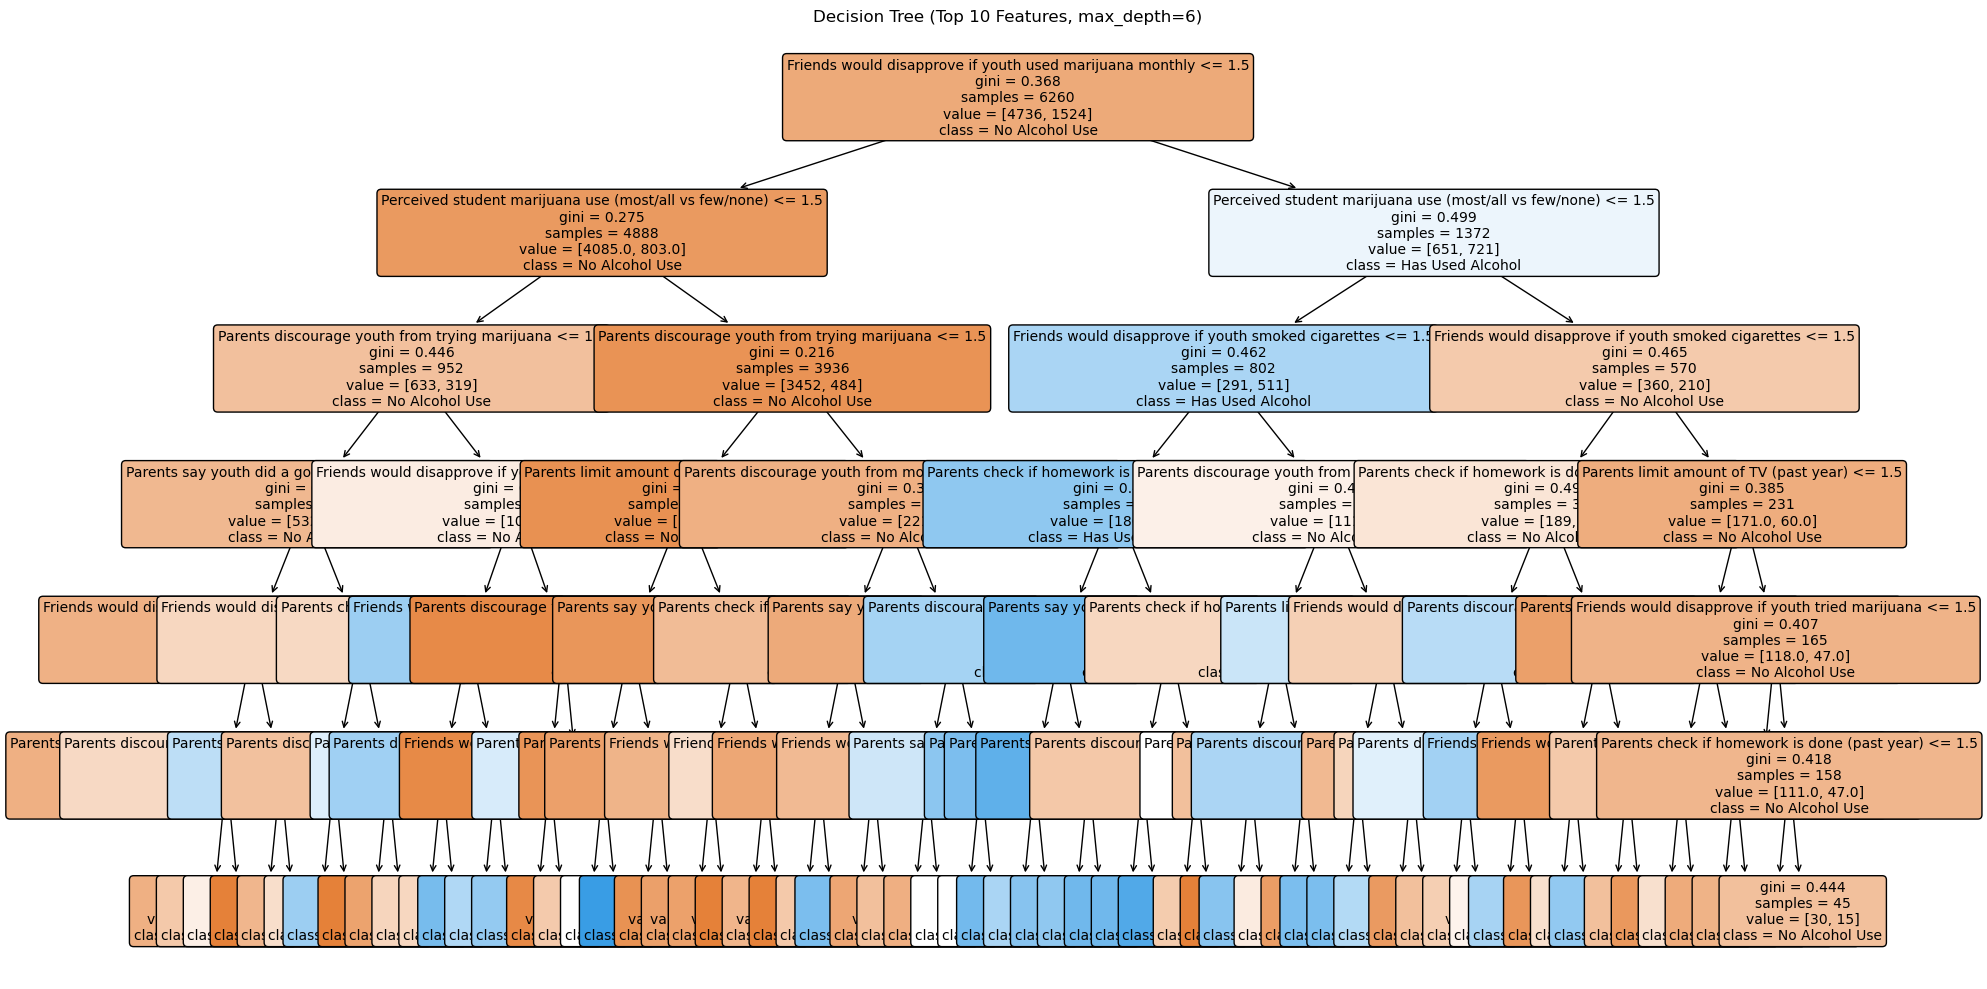

In [47]:
# Ensure you're renaming only relevant feature names
relabeled_features = [column_rename_map.get(col, col) for col in top_10_features]

plt.figure(figsize=(20, 10))
plot_tree(
    best_model,
    feature_names=relabeled_features,
    class_names=["No Alcohol Use", "Has Used Alcohol"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title(f"Decision Tree (Top 10 Features, max_depth={best_depth})")
plt.tight_layout()
plt.show()


In [48]:

# Print text version
tree_summary = export_text(best_model, feature_names=relabeled_features)
print(tree_summary)

|--- Friends would disapprove if youth used marijuana monthly <= 1.50
|   |--- Perceived student marijuana use (most/all vs few/none) <= 1.50
|   |   |--- Parents discourage youth from trying marijuana <= 1.50
|   |   |   |--- Parents say youth did a good job (past year) <= 1.50
|   |   |   |   |--- Friends would disapprove if youth smoked cigarettes <= 1.50
|   |   |   |   |   |--- Parents discourage youth from monthly marijuana use <= 1.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Parents discourage youth from monthly marijuana use >  1.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- Friends would disapprove if youth smoked cigarettes >  1.50
|   |   |   |   |   |--- Parents discourage youth from monthly marijuana use <= 1.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Parents discourage youth from monthly marijuana use >  1.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- Parents say youth did a good job (past year) >  1

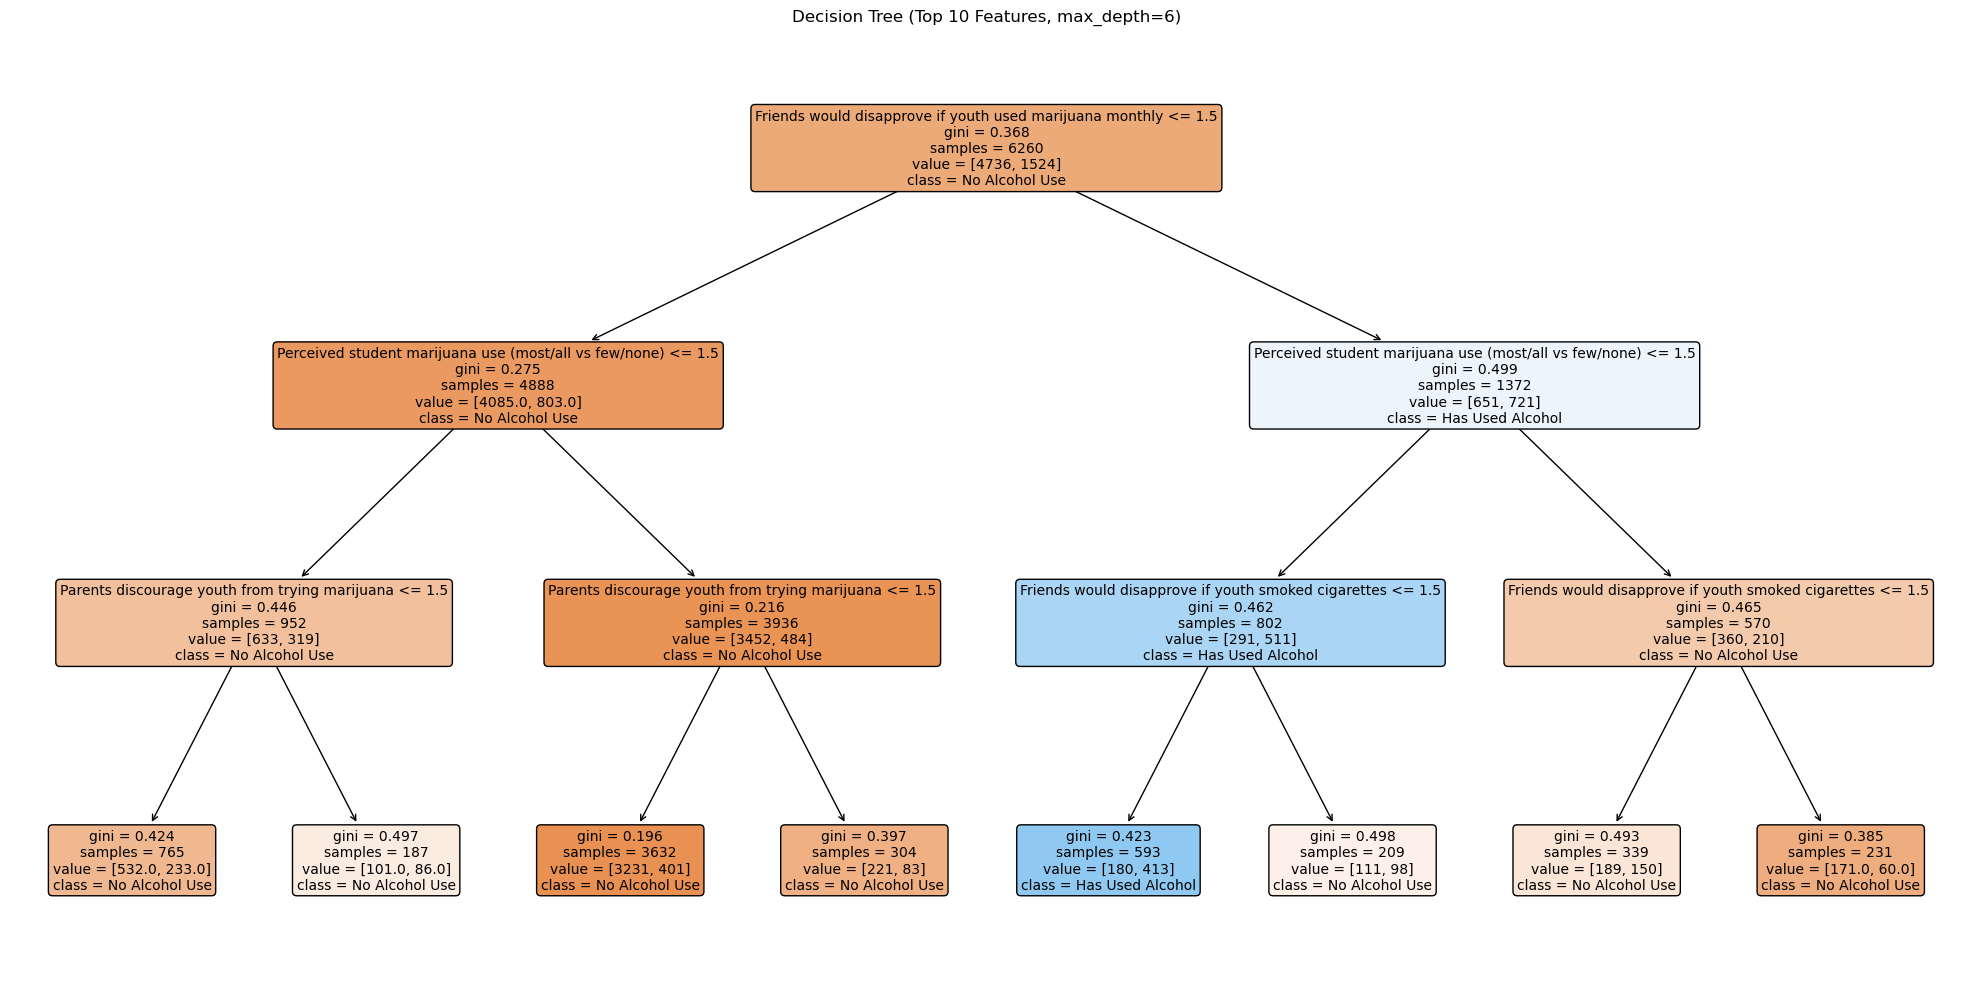

In [49]:
best_model1 = DecisionTreeClassifier(max_depth=3, random_state=42)
best_model1.fit(X_train, y_train)
#  Visualize decision tree
relabeled_features = [column_rename_map.get(col, col) for col in top_10_features]
plt.figure(figsize=(20, 10))
plot_tree(
    best_model1,
    feature_names=relabeled_features,
    class_names=["No Alcohol Use", "Has Used Alcohol"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title(f"Decision Tree (Top 10 Features, max_depth={best_depth})")
plt.tight_layout()
plt.show()

In [50]:
print("Criterion used:", best_model.criterion)
gini_values = best_model.tree_.impurity
samples_per_node = best_model.tree_.n_node_samples
for i in range(len(gini_values)):
    print(f"Node {i}: Gini = {gini_values[i]:.4f}, Samples = {samples_per_node[i]}")



Criterion used: gini
Node 0: Gini = 0.3684, Samples = 6260
Node 1: Gini = 0.2746, Samples = 4888
Node 2: Gini = 0.4456, Samples = 952
Node 3: Gini = 0.4236, Samples = 765
Node 4: Gini = 0.4002, Samples = 600
Node 5: Gini = 0.3967, Samples = 583
Node 6: Gini = 0.3951, Samples = 572
Node 7: Gini = 0.4628, Samples = 11
Node 8: Gini = 0.4844, Samples = 17
Node 9: Gini = 0.4978, Samples = 15
Node 10: Gini = 0.0000, Samples = 2
Node 11: Gini = 0.4824, Samples = 165
Node 12: Gini = 0.4773, Samples = 155
Node 13: Gini = 0.4178, Samples = 37
Node 14: Gini = 0.4884, Samples = 118
Node 15: Gini = 0.4800, Samples = 10
Node 16: Gini = 0.4444, Samples = 9
Node 17: Gini = 0.0000, Samples = 1
Node 18: Gini = 0.4968, Samples = 187
Node 19: Gini = 0.4840, Samples = 151
Node 20: Gini = 0.4467, Samples = 98
Node 21: Gini = 0.3343, Samples = 33
Node 22: Gini = 0.4800, Samples = 65
Node 23: Gini = 0.4956, Samples = 53
Node 24: Gini = 0.4824, Samples = 32
Node 25: Gini = 0.3628, Samples = 21
Node 26: Gini = 

# Multi-class Classification: IRCIGFM

d:\Software\Anaconda\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
d:\Software\Anaconda\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
d:\Software\Anaconda\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


{'Decision Tree': {'max_depth': 3}, 'Random Forest': {'max_depth': 20, 'n_estimators': 50}, 'Gradient Boosting': {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 25}}


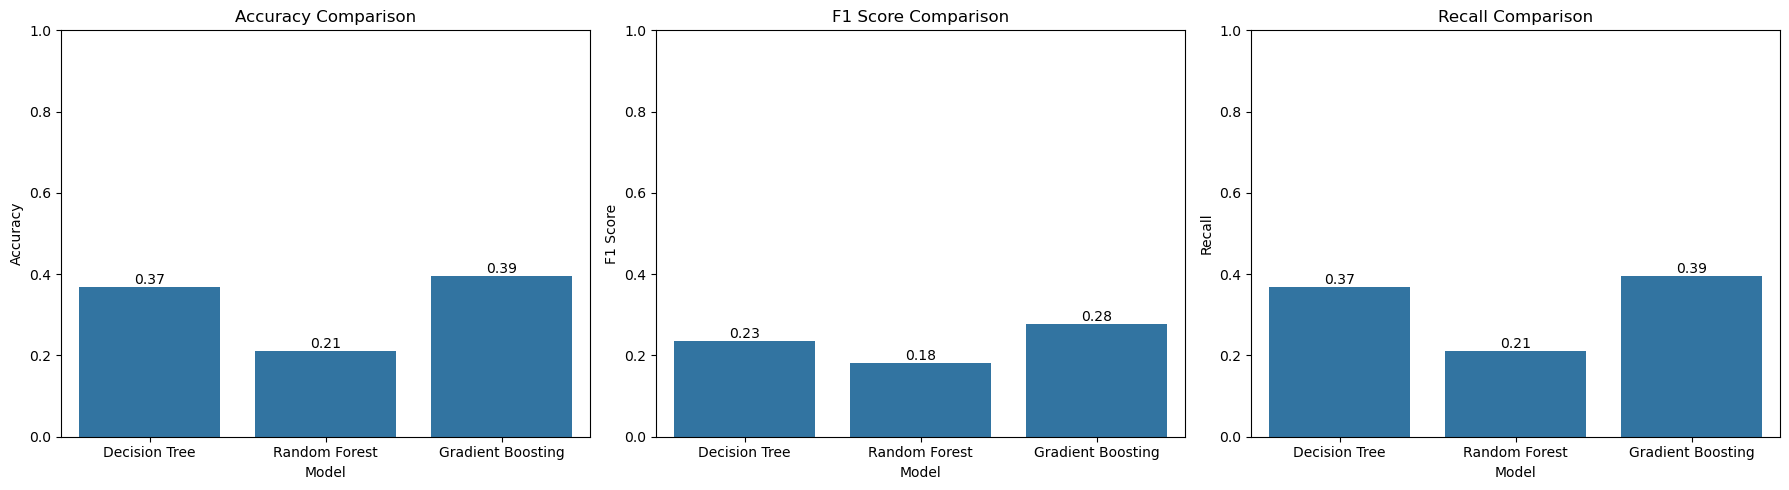

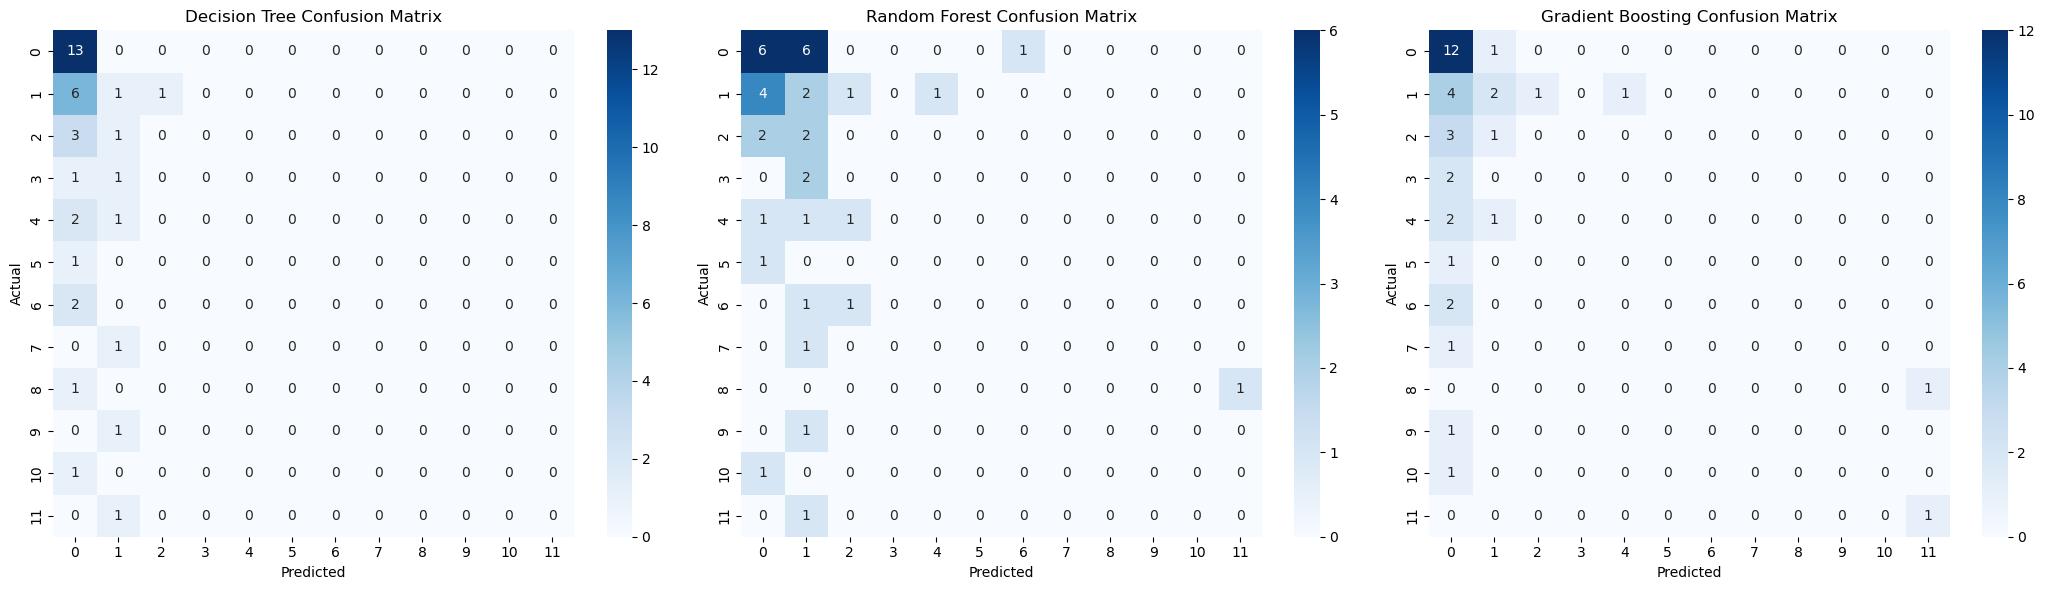

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, recall_score

# Load the dataset
youth_df = pd.read_csv('youth_data.csv')

# Define predictor variables
predictor_vars = [
    'PARCHKHW', 'PARHLPHW', 'PRCHORE2', 'PRLMTTV2', 'PARLMTSN', 'PRGDJOB2',
    'PRPROUD2', 'PRPKCIG2', 'PRMJEVR2', 'PRMJMO', 'PRALDLY2',
    'FRDPCIG2', 'FRDMEVR2', 'FRDMJMON', 'FRDADLY2',
    'SCHFELT', 'TCHGJOB', 'AVGGRADE', 'STNDSCIG', 'STNDSMJ', 'STNDALC'
]

# Clean and prepare the data
multi_df = youth_df[predictor_vars + ['IRCIGFM']].copy()
multi_df.replace([91, 93, 94, 95, 97, 98, 99, 991, 993, 994, 997, 998, 999], np.nan, inplace=True)
multi_df.dropna(inplace=True)

# Filter classes with at least 2 samples
valid_classes = multi_df['IRCIGFM'].value_counts()
multi_df = multi_df[multi_df['IRCIGFM'].isin(valid_classes[valid_classes >= 2].index)]

# Define features and target
X = multi_df[predictor_vars]
y = multi_df['IRCIGFM']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Feature selection
selector = SelectKBest(score_func=f_classif, k=10)
X_train_sel = selector.fit_transform(X_train, y_train)
X_test_sel = selector.transform(X_test)
selected_features = X.columns[selector.get_support()]

# Define models and parameters
models_params = {
    "Decision Tree": (
        DecisionTreeClassifier(random_state=42),
        {'max_depth': [1,3,7,10]}
    ),
    "Random Forest": (
        RandomForestClassifier(random_state=42),
        {'n_estimators': [25,50,100,75], 'max_depth': [5, 10, 20, 25]}
    ),
    "Gradient Boosting": (
        GradientBoostingClassifier(random_state=42),
        {'n_estimators': [20, 25, 50, 100], 'max_depth': [5, 10, 15], 'learning_rate': [0.1, 1.0, 0.01]}
    ),
}

# Storage for evaluation results
eval_results = []
conf_matrices = {}
best_params_dict = {}

# Train, evaluate, and collect metrics
for name, (model, params) in models_params.items():
    grid = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train_sel, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_sel)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)

    eval_results.append({
        "Model": name,
        "Accuracy": acc,
        "F1 Score": f1,
        "Recall": recall
    })
    conf_matrices[name] = cm
    best_params_dict[name] = grid.best_params_

print(best_params_dict)
# Create evaluation dataframe
eval_df = pd.DataFrame(eval_results)

# Plot evaluation metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
metrics = ['Accuracy', 'F1 Score', 'Recall']

for i, metric in enumerate(metrics):
    sns.barplot(data=eval_df, x='Model', y=metric, ax=axes[i])
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_ylim(0, 1)
    axes[i].bar_label(axes[i].containers[0], fmt="%.2f")

plt.tight_layout()
plt.show()

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(21, 6))
for ax, (model_name, cm) in zip(axes, conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'{model_name} Confusion Matrix')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()


# Regression: CIGMDAYS

In [67]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

reg_df = youth_df[predictor_vars + ['CIGMDAYS']].copy()
reg_df = reg_df.replace([91, 93, 94, 95, 97, 98, 99, 991, 993, 994, 997, 998, 999], np.nan)
reg_df.dropna(inplace=True)

X_reg = reg_df[predictor_vars]
y_reg = reg_df['CIGMDAYS']
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)
from sklearn.model_selection import GridSearchCV

# Decision Tree
dtr_params = {'max_depth': [3, 5, 7, 10]}
dtr_grid = GridSearchCV(DecisionTreeRegressor(random_state=42), dtr_params, cv=5)
dtr_grid.fit(X_train_r, y_train_r)

# Random Forest
rfr_params = {'n_estimators': [100, 200], 'max_depth': [5, 10, 15]}
rfr_grid = GridSearchCV(RandomForestRegressor(random_state=42), rfr_params, cv=5)
rfr_grid.fit(X_train_r, y_train_r)

# Gradient Boosting
gbr_params = {'n_estimators': [100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.05, 0.1]}
gbr_grid = GridSearchCV(GradientBoostingRegressor(random_state=42), gbr_params, cv=5)
gbr_grid.fit(X_train_r, y_train_r)


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200]})

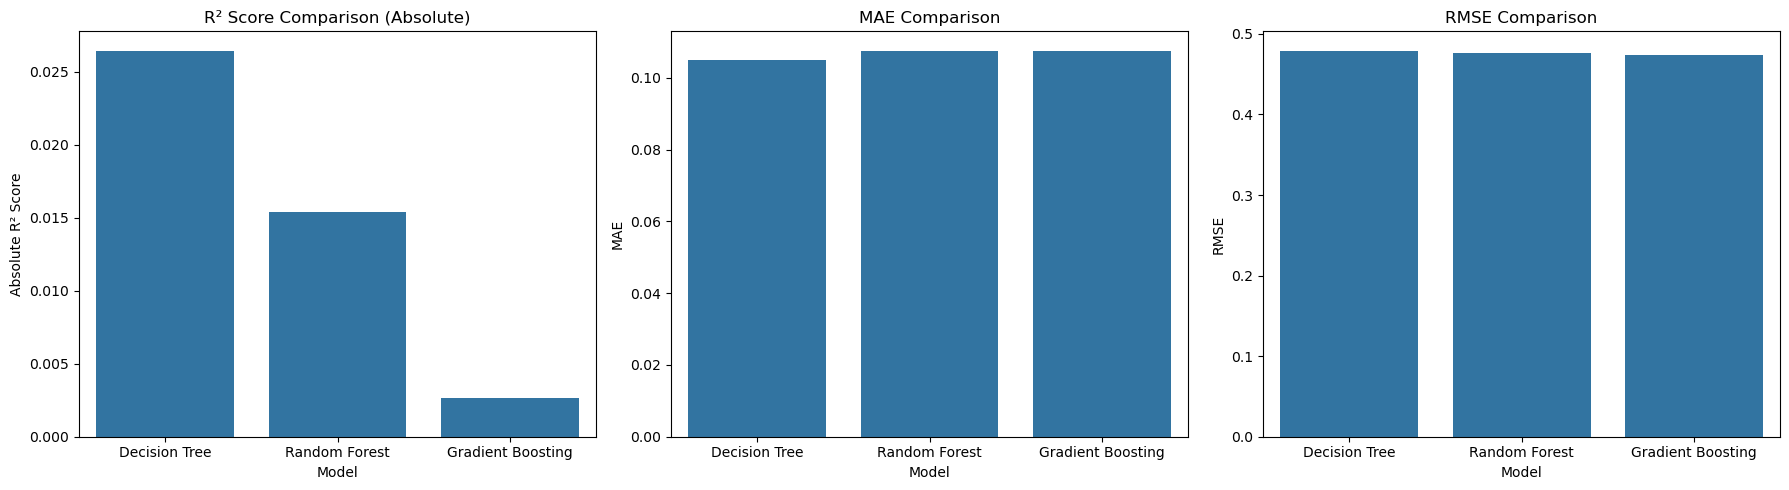

In [69]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Predictions
dtr_pred = dtr_grid.predict(X_test_r)
rfr_pred = rfr_grid.predict(X_test_r)
gbr_pred = gbr_grid.predict(X_test_r)

# Compute metrics
models = ['Decision Tree', 'Random Forest', 'Gradient Boosting']
r2_scores = [
    r2_score(y_test_r, dtr_pred),
    r2_score(y_test_r, rfr_pred),
    r2_score(y_test_r, gbr_pred)
]
maes = [
    mean_absolute_error(y_test_r, dtr_pred),
    mean_absolute_error(y_test_r, rfr_pred),
    mean_absolute_error(y_test_r, gbr_pred)
]
rmses = [
    np.sqrt(mean_squared_error(y_test_r, dtr_pred)),
    np.sqrt(mean_squared_error(y_test_r, rfr_pred)),
    np.sqrt(mean_squared_error(y_test_r, gbr_pred))
]

# Create DataFrame for metrics
metrics_df = pd.DataFrame({
    'Model': models,
    'R2 Score': r2_scores,
    'MAE': maes,
    'RMSE': rmses
})
# Plotting (with positive R² for display only)
metrics_df['Abs R2 Score'] = metrics_df['R2 Score'].abs()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# R2 Score (absolute for visualization)
sns.barplot(ax=axes[0], x='Model', y='Abs R2 Score', data=metrics_df)
axes[0].set_title('R² Score Comparison (Absolute)')
axes[0].set_ylabel('Absolute R² Score')

# MAE
sns.barplot(ax=axes[1], x='Model', y='MAE', data=metrics_df)
axes[1].set_title('MAE Comparison')

# RMSE
sns.barplot(ax=axes[2], x='Model', y='RMSE', data=metrics_df)
axes[2].set_title('RMSE Comparison')

plt.tight_layout()
plt.show()
